In [1]:
import torch
import pandas as pd
from MyRNNdata import load_data_nmt
from MyAtten import TransformerEncoder, TransformerDecoder
from MyRNN import EncoderDecoder, train_seq2seq, pred_seq2seq, bleu
from Myplot import show_heatmaps

loss 0.030, 29465.1 tokens/sec on cuda


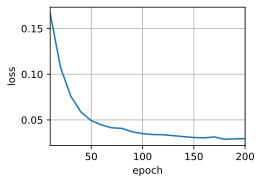

In [2]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, "cuda"
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab),
    key_size,
    query_size,
    value_size,
    num_hiddens,
    norm_shape,
    ffn_num_input,
    ffn_num_hiddens,
    num_heads,
    num_layers,
    dropout,
)
decoder = TransformerDecoder(
    len(tgt_vocab),
    key_size,
    query_size,
    value_size,
    num_hiddens,
    norm_shape,
    ffn_num_input,
    ffn_num_hiddens,
    num_heads,
    num_layers,
    dropout,
)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [3]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = pred_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f"{eng} => {translation}, ", f"bleu {bleu(translation, fra, k=2):.3f}")

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est malade .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [4]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps)
)
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

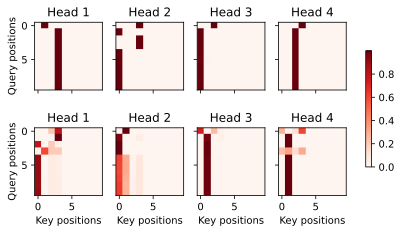

In [5]:
show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [6]:
dec_attention_weights_2d = [
    head[0].tolist()
    for step in dec_attention_weight_seq
    for attn in step
    for blk in attn
    for head in blk
]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values
)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps)
)
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(
    1, 2, 3, 0, 4
)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

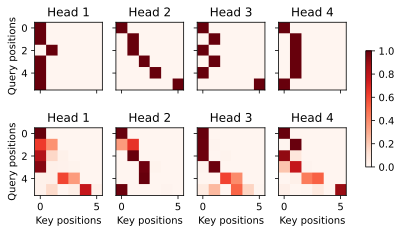

In [7]:
# Plusonetoincludethebeginning-of-sequencetoken
show_heatmaps(
    dec_self_attention_weights[:, :, :, : len(translation.split()) + 1],
    xlabel="Key positions",
    ylabel="Query positions",
    titles=["Head %d" % i for i in range(1, 5)],
    figsize=(7, 3.5),
)

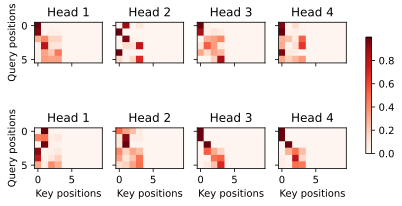

In [8]:
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))